# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analyse du dataset

**Charger les données**

In [28]:
data = pd.read_csv('./Data/coffee-prices-historical-data.csv')
print(data.shape)
data.head()

(12542, 2)


,date,value
0,1973-08-20,0.6735
1,1973-08-21,0.6710
2,1973-08-22,0.6580
3,1973-08-23,0.6675
4,1973-08-24,0.6660


**Nettoyage**

In [ ]:
#Valeur nulles ?
data.isnull().sum()
#Pas de valeur nulles

# La colonne date doit être au format datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Colonne dans variables
coffe_price = data['value'].to_numpy()
date = data['date']

Index(['date', 'value'], dtype='object')


**Plot de la serie**

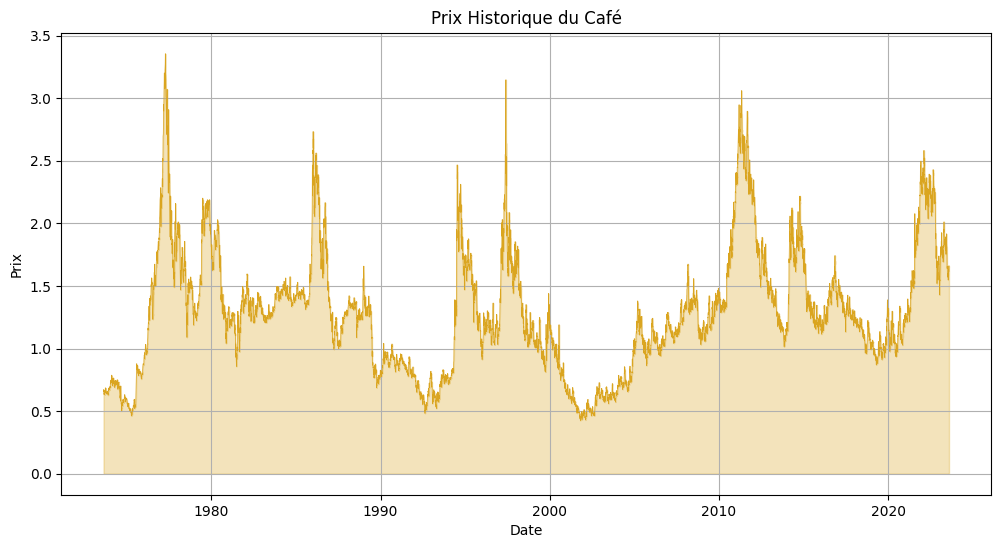

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(date, coffe_price, color='goldenrod', linewidth=0.5)
plt.fill_between(date, coffe_price, color='goldenrod', alpha=0.3)
plt.title('Prix Historique du Café')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.grid(True)
plt.show()